In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

In [4]:
tf.config.set_visible_devices(
    physical_devices[1], 'GPU'
)

# Data Loading

Data pre-processing details:

* The only pre-processing they do is subtracting the mean RGB value, computed on the training set, from each pixel.

Data augmentation:

* To further augment the training set, the crops underwent random horizontal flipping and random RGB colour shift.

In [5]:
path_train = 'CINIC10/train/'
path_val = 'CINIC10/valid/'
path_test = 'CINIC10/test/'
data_dir_train = pathlib.Path(path_train)
data_dir_val = pathlib.Path(path_val)
data_dir_test = pathlib.Path(path_test)

In [6]:
list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_val/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*')])

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [9]:
def decode_img(img, dsize):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [dsize[0], dsize[1]])

In [10]:
def process_path(file_path):
    size = (224,224)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img,size )
    return img, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_valid = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
def augmentation(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta=0.5)
    return x, y

In [14]:
def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [15]:
def prepare_for_training(ds, training = False, cache=True, shuffle_buffer_size=1000, batch_size = 128):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.map(normalize)
    if training:
        ds = ds.map(augmentation)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [16]:
train_ds = prepare_for_training(labeled_ds_train, training = True, batch_size=64)
val_ds = prepare_for_training(labeled_ds_valid, batch_size = 64)
test_ds = prepare_for_training(labeled_ds_test, batch_size = 64)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# VGG Details

* This architecture was built based on AlexNet, by visualizing the features in a fully AlexNet trained model
* optimizer = SGD 
* batch_size = 256 
* momentum = 0.9 
* weight decay = 0.0005 
* weights random initialization: mean-0 variance-0.01
* bias = 0
* lr_initial = 0.01 (reduced three time prior termination) 
* num_epochs = 74
* cross-entropy loss 

# Model Definition

A little vit verbose but in the next models we are going to define the models in a smarter way.

In [17]:
def Model(num_classes = 1000):
    kernel_init = tf.keras.initializers.GlorotNormal()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64,kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(256, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', strides=(1,1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, 'softmax')
    ])
    return model

In [18]:
model = Model(10)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 128)     5

# Training

In [20]:
model.compile(optimizer=tfa.optimizers.SGDW(momentum=0.9,weight_decay=0.0005,learning_rate=0.01),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [21]:
history = model.fit(train_ds, 
                    epochs = 74, 
                    steps_per_epoch=100, 
                    verbose = 1,
                    validation_data = val_ds,
                    validation_steps = 100)

Train for 100 steps, validate for 100 steps
Epoch 1/74
100/100 [==============================] - 66s 664ms/step - loss: 3.4419 - accuracy: 0.1775 - val_loss: 373.0759 - val_accuracy: 0.1008
Epoch 2/74
100/100 [==============================] - 57s 572ms/step - loss: 3.4753 - accuracy: 0.2048 - val_loss: 5.1507 - val_accuracy: 0.2275
Epoch 3/74
100/100 [==============================] - 57s 566ms/step - loss: 3.3673 - accuracy: 0.2188 - val_loss: 2.8874 - val_accuracy: 0.2223
Epoch 4/74
100/100 [==============================] - 57s 571ms/step - loss: 3.1280 - accuracy: 0.2377 - val_loss: 3.6270 - val_accuracy: 0.1323
Epoch 5/74
100/100 [==============================] - 57s 572ms/step - loss: 2.9958 - accuracy: 0.2497 - val_loss: 2.6104 - val_accuracy: 0.1467
Epoch 6/74
100/100 [==============================] - 58s 577ms/step - loss: 2.8284 - accuracy: 0.2647 - val_loss: 3.0893 - val_accuracy: 0.1434
Epoch 7/74
100/100 [==============================] - 58s 575ms/step - loss: 2.6834 

# Evaluation

In [22]:
loss_test, accuracy_test = model.evaluate(test_ds,
                                         verbose = 1,
                                         steps = 5)

5/5 [==============================] - 6s 1s/step - loss: 1.1032 - accuracy: 0.6156


In [23]:
loss_test, accuracy_test

(1.1032184481620788, 0.615625)

# Training results visualization

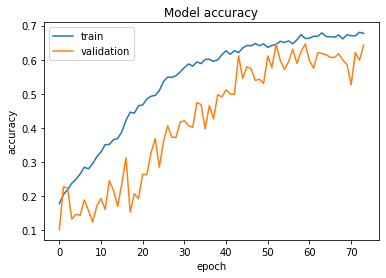

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

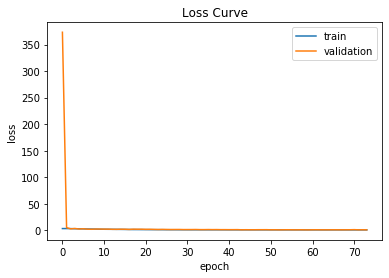

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()